<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
Multi-class Classification with Logistic Regression
</h1><br>

For this exercise we'll use logistic regression to recognize hand-written digits (0 to 9). The recognition of hand-written digits is a multi-class classification problem with $k = 10$ classes, i.e $y^i \in \{1, 2, 3, ..., 10\}$. As a result, to use logistic regression, we have to fit 10 classifiers using  **one-vs-all** technique. Therefore, for each class we'll build a classifier where that class would be the *positive* class and all other classes would be the *negative* class. After fitting the 10 classifiers, we use the 10 models in predicting each training example $x^i$ and pick the class that has the highest probability from those 10 models; i.e would end up with column vector $h_\theta(x^i) \in \mathbb{R}^k$.

Let's get started by imporitng the required libraries.

In [1]:
# Import libraries and set up notebook global style
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat, whosmat # load Matlab files and inspect objects in those files before loading them
import scipy.optimize as opt
 

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight');

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Functions
</h2><br>
We'll write the functions needed to solve regularized logistic regression and implement Neural Network.

In [2]:
# Define sigmoid fn
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


# Compute cost of regularized logistic regression
def cost_reg(theta, X, y, lambda_):
    '''
    theta: parameters array
    X: features matrix m x (n + 1)
    y: target variable column vector m x 1
    lambda: shrinkage parameter --> scalar
    Return: cost with shrinkage penalty added --> scalar
    '''
    theta = theta.reshape(-1, 1)
    m = y.shape[0]
    
    z = X.dot(theta)
    hyp = sigmoid(z) # hypothesis
    error = np.multiply(y, np.log(hyp)) + np.multiply(1 - y, np.log(1 - hyp))
    shrinkage_penalty = (lambda_ /(2 * m)) * (np.power(theta[1:, :], 2))
    cost = - (1 / m) * np.sum(error) + np.sum(shrinkage_penalty)
    
    return cost


# Compute the gradients of regularized logistic regression
def gradient_reg(theta, X, y, lambda_):
    '''
    theta: parameters array
    X: features matrix m x (n + 1)
    y: target variable column vector m x 1
    lambda: shrinkage parameter --> scalar
    Return: gradient array
    '''
    theta = theta.reshape(-1, 1)
    m = y.shape[0]
    
    z = X.dot(theta)
    hyp = sigmoid(z)
    error = hyp - y
    grad = (1 / m) * (X.T.dot(error))
    grad[1:, :] = grad[1:, :] + (lambda_ / m) * theta[1:, :]
    
    return grad.ravel()


# Define one-vs-all k classifier
def one_vs_all(X, y, num_classes, lambda_):
    '''
    X: features matrix m x (n + 1)
    y: target variable column vector m x 1
    num_classes: scalar; number of classes at hand
    lambda: shrinkage parameter --> scalar
    Return: theta matrix k x (n + 1) where each row is a classifier and each column is a featute.
            i.e. each cell is a fauture weight for the classifier on the same row.
    '''
    # Initializes zero theta parameter and theta matrix
    init_theta = np.zeros(X.shape[1])
    
    # Theta matrix will store theta parameters for all k models
    theta_matrix = np.zeros((num_classes, X.shape[1]))
    
    for i in range(1, num_classes + 1):
        # Would be 1 for the i class and 0 for all ther classes i.e one-vs-all
        y_i = (y == i) * 1 
        
        # Compute theta
        result = opt.fmin_tnc(
            func = cost_reg, x0=init_theta, args=(X, y_i, lambda_), fprime=gradient_reg)
        
        # Store theta parameters array in theta matrix
        theta_matrix[i - 1] = result[0]
    
    return theta_matrix


# Define predict fn for one-vs-all
def predict_one_vs_all(theta, X):
    '''
    X: features matrix m x (n + 1)
    theta: theta matrix k x (n + 1
    Return: predictions column vector m x 1
    '''
    pred = X.dot(theta.T) # will leave us with matrix m * k where each column represents the logit
    hyp = sigmoid(pred)
    pred = (hyp.argmax(axis=1) + 1) # it will give us the index of the highest probability
                                      # per row (column index) which will allow us to assign
                                      # the class for the training example
    return pred.reshape(-1, 1)


# Define accuracy fn
def accuracy(predictions, y):
    '''
    predictions: predictions' class
    y: Actual class for each m examples --> m x 1 column vector
    Return: Accuracy rate --> scalar
    '''
    accuracy = np.mean(predictions == y)
    
    return f"accuracy = {accuracy * 100:.2f}%"

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Regularized Logistic Regression: Multi-class Classification
</h2><br>
Below is a refresher from logistic regression notebook.

The hypothesis function is:
$$P(y^i = 1/X,\theta) = h_\theta(X^i) = \frac {1} {1+ \exp^{-\theta^{T}X^i}}$$

$$\Rightarrow\Big(\frac {P(y^i = 1/X,\theta)} {1 - P(y^i = 1/X,\theta)}\Big) = \exp^{\theta^{T}X^i}$$

$$\Rightarrow log\Big(\frac {P(y^i = 1/X,\theta)} {1 - P(y^i = 1/X,\theta)}\Big) = {\theta^{T}X^i}$$

The cost function will be:
$$J(\theta) = - \frac {1} {m} \sum_{i = 1}^{m} \big\{ y^ilog(h_\theta(X^i)) + (1 - y^i)log(1 - h_\theta(X^i))\big\} + \frac {\lambda} {2m} \sum_{j = 1}^{n}\theta_j^2$$
Since we don't apply the regularization on the bias (intercept); therefore, we'll have two update equations for the gradient descent algorithm:
$$\theta_0 = \theta_0 - \alpha\sum_{i = 1}^{m} (h_\theta(X^i) - y^i)x_0^i$$
$$\theta_j = \theta_j(1 - \alpha\frac{\lambda}{m}) - \alpha\sum_{i = 1}^{m} (h_\theta(X^i) - y^i)x_j^i\quad;\,j = 1, 2 , ..., n$$

Finally, since it's *one-vs-all* classification, we'll have k hypothesis for each example:
Train a logistic regression classifier $h_\theta^i(X)$ for each class $i$ to predict the probability that $y = i$.

The unique classes we have: [ 1  2  3  4  5  6  7  8  9 10]
Below is a sample of 20 images of the digits we have:


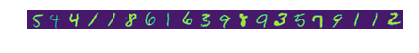

In [3]:
# Load data
data = loadmat('../data/ex3data1.mat')
y = data['y']
X = data['X']

# Get the number of classes we have using unique method
num_classes = len(np.unique(y))
print(f"The unique classes we have: {np.unique(y)}")

# randomly select 20 images to show them
sample = np.random.choice(X.shape[0], 20)
print("Below is a sample of 20 images of the digits we have:")
plt.imshow(X[sample, :].reshape(-1, 20).T)
plt.axis('off');

The Matlab file contains two objects: 
* $X$: feature matrix with 400 features. Each example is a 20 pixels x 20 pixels image $\rightarrow$ 400 features.
* $y$: target variable. Note that 0 is 10 in the data for indexing purposes.
* $m = 5000$ training example.

In [4]:
# Adding columns of ones for the intercept
X = np.insert(X, 0, np.ones(X.shape[0]), axis=1)

# Run the OneVsAll to get all models
lambda_ = 0.1
all_theta = one_vs_all(X, y, num_classes, lambda_)

# Predict the training examples class
pred = predict_one_vs_all(all_theta, X)
accuracy(pred, y)

'accuracy = 96.46%'

The accuracy of using 10 clasifiers is close to 96.46%. We could've tried adding some non-linearities to the model as well as tuning the hyperparameter $\lambda$ using cross validation to get the most out of the logistic regression model.

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Conclusion
</h2><br>
A few takeaway points:
* We didn't tune shrinkage parameter to pick the soft spot of *bias-variance* trade-off that may've helped us in improving the accuracy rate.
    * We could've also add non-linearity to the features but it may become very complex so fast since adding $2^{nd}$ degree polynomial will grow at ${O}(n^2)$.